In [ ]:
%%capture
!pip install transformers pytorch-lightning --quiet
!sudo apt -qq install git-lfs
!apt-get install p7zip-full
!git config --global credential.helper store

In [ ]:
import math
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics

from huggingface_hub import HfApi, HfFolder, Repository, notebook_login
from google.colab import drive
from pathlib import Path
from sklearn import metrics
from transformers import ViTFeatureExtractor, ViTForImageClassification
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

In [ ]:
''' if data_dir.exists():
    shutil.rmtree(data_dir) '''

data_dir = Path("archive/dataset")
drive.mount("/content/gdrive", force_remount=True)
!p7zip -d './gdrive/My Drive/face_ds.7z'

Mounted at /content/gdrive

7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan ./gdrive/My Drive/                            1 file, 2097605478 bytes (2001 MiB)

Extracting archive: ./gdrive/My Drive/face_ds.7z
--
Path = ./gdrive/My Drive/face_ds.7z
Type = 7z
Physical Size = 2097605478
Headers Size = 491724
Method = LZMA2:30
Solid = +
Blocks = 1

  0%      0% 8        0% 48 - archive/dataset/Ahegao/cropped_emotions.17684~ahegao.png                                                                    0% 65 - archive/dataset/Ahegao/cropped_emotions.188461~ahegao.png

In [ ]:
ds = ImageFolder(data_dir)
indices = torch.randperm(len(ds)).tolist()
n_val = math.floor(len(indices) * .15)
train_ds = torch.utils.data.Subset(ds, indices[:-n_val])
val_ds = torch.utils.data.Subset(ds, indices[-n_val:])
len(indices[:-n_val]), len(indices[-n_val:])

label2id = {}
id2label = {}

for i, class_name in enumerate(ds.classes):
    label2id[class_name] = str(i)
    id2label[str(i)] = class_name

In [ ]:
class ImageClassificationCollator:
    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor

    def __call__(self, batch):
        encodings = self.feature_extractor([x[0] for x in batch], return_tensors="pt")
        encodings["labels"] = torch.tensor([x[1] for x in batch], dtype=torch.long)
        return encodings

In [ ]:
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k", from_pt=True)
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label
)
collator = ImageClassificationCollator(feature_extractor)
train_loader = DataLoader(train_ds, batch_size=8, collate_fn=collator, num_workers=2, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, collate_fn=collator, num_workers=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
"""
class Classifier(pl.LightningModule):
    def __init__(self, model, lr: float=2e-5, **kwargs):
        super().__init__()
        self.save_hyperparameters("lr", *list(kwargs))
        self.model = model
        self.forward = self.model.forward
        self.val_acc = Accuracy(
            task="multiclass" if model.config.num_labels > 2 else "binary",
            num_classes=model.config.num_labels
        )

    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"train_loss", outputs.loss)
        return outputs.loss

    def validation_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"val_loss", outputs.loss)
        acc = self.val_acc(outputs.logits.argmax(1), batch["labels"]) # 100 batch size
        self.log(f"val_acc", acc, prog_bar=True)
        return outputs.loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
"""

# https://www.youtube.com/watch?v=e6Nw01v2X4s
class Classifier(pl.LightningModule):
    def __init__(self, model, lr: float=2e-5, **kwargs):
        super().__init__()
        self.save_hyperparameters("lr", *list(kwargs))
        self.model = model
        self.forward = self.model.forward
        self.accuracy = torchmetrics.Accuracy(
            task="multiclass",num_classes=model.config.num_labels
        )
        self.f1_score = torchmetrics.F1Score(
            task="multiclass",num_classes=model.config.num_labels
        )
        self.confusion_matrix = torchmetrics.ConfusionMatrix(
            task="multiclass",num_classes=model.config.num_labels
        )

    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"train_loss", outputs.loss)
        return outputs.loss

    def validation_step(self, batch, batch_idx):
        outputs = self(**batch)
        accuracy = self.accuracy(outputs.logits.argmax(1), batch["labels"])
        f1_score = self.f1_score(outputs.logits.argmax(1), batch["labels"])
        confusion_matrix = self.confusion_matrix(outputs.logits.argmax(1), batch["labels"])
# "train_confusion_matrix": confusion_matrix},
# "confusion_matrix": torch.tensor(confusion_matrix, device='cuda:0').float().mean()
        self.log_dict({
            "loss": outputs.loss,
            "accuracy": accuracy,
            "f1_score": f1_score,
            "confusion_matrix": torch.tensor(confusion_matrix, device='cuda:0').float().mean()},
            on_step=False, on_epoch=True, prog_bar=True, logger=True)

        # print(confusion_matrix(outputs.logits.argmax(1), batch["labels"]))
        # self.log("train_confusion_matrix", torch.tensor(confusion_matrix, device='cuda:0').float().mean())
        return outputs.loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [ ]:
pl.seed_everything(12)
classifier = Classifier(model, lr=2e-5)
trainer = pl.Trainer(accelerator="gpu", devices=1, precision=16, max_epochs=1)
trainer.fit(classifier, train_loader, val_loader)

INFO:lightning_fabric.utilities.seed:Seed set to 12
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type                      | Params
---------------------------------------------------------------
0 | model            | ViTForImageClassification | 85.8 M
1 | accuracy         | MulticlassAccuracy        | 0     
2 | f1_score         | MulticlassF1Score         | 0     
3 | confusion_matrix | MulticlassConfusionMatrix | 0     
----------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

<ipython-input-46-976efc1f509a>:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "confusion_matrix": torch.tensor(confusion_matrix, device='cuda:0').float().mean()},


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


Preds:  tensor([3, 4, 4, 3, 2, 3, 3, 3])
Labels: tensor([3, 4, 4, 3, 2, 3, 1, 4])


ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of labels (2).

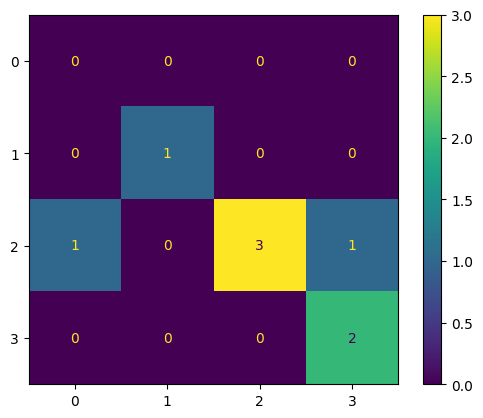

In [ ]:
val_batch = next(iter(val_loader))
outputs = model(**val_batch)
print('Preds: ', outputs.logits.softmax(1).argmax(1))
print('Labels:', val_batch['labels'])
# (outputs.logits.cpu().data.numpy().argmax(1)
confusion_matrix = metrics.confusion_matrix(outputs.logits.softmax(1).argmax(1), val_batch["labels"])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot()
plt.show()

In [ ]:
notebook_login()

In [ ]:
model_id = "SpqyqBas1DTrZke05YAEsTpMKwMh6cR7"

description = """
Food model
"""
task_name = "Image Classification"
task_type = 'image-classification'
metric_name = 'Accuracy'
metric_type = 'accuracy'
metric_value = trainer.callback_metrics['val_acc'].item()

if Path('./model').exists():
    shutil.rmtree('./model')

token = HfFolder().get_token()
if not token:
    raise RuntimeError("You must log in to push to hub! Run notebook_login() in the cell above.")

hf_username = HfApi().whoami()['name']
model_url = HfApi().create_repo(token=token, repo_id=model_id, exist_ok=True)
model_repo = Repository("./model", clone_from=model_url, use_auth_token=token, git_email=f"{hf_username}@users.noreply.huggingface.co", git_user=hf_username)
model.save_pretrained(model_repo.local_dir)
feature_extractor.save_pretrained(model_repo.local_dir)

tensorboard_logs_path = next(Path(trainer.logger.log_dir).glob('events.out*'))
model_repo_logs_path = Path(model_repo.local_dir) / 'runs'
model_repo_logs_path.mkdir(exist_ok=True, parents=True)
shutil.copy(tensorboard_logs_path, model_repo_logs_path)

example_images_dir = Path(model_repo.local_dir) / 'images'
example_images_dir.mkdir(exist_ok=True, parents=True)
image_markdown_template = '''
#### {class_name}

![{class_name}](images/{example_image_path})
'''
example_images_markdown = ""
for class_idx, class_name in enumerate(ds.classes):
    folder = ds.root / class_name
    image_path = sorted(folder.glob('*'))[0]
    example_image_path = example_images_dir / f"{class_name.replace(' ', '_')}{image_path.suffix}"
    shutil.copy(image_path, example_image_path)
    example_images_markdown += image_markdown_template.format(
        class_name=class_name,
        example_image_path=example_image_path.name
    )

readme_txt = f"""
---
tags:
- image-classification
- pytorch
- huggingpics
metrics:
- {metric_type}

model-index:
- name: {model_id}
  results:
  - task:
      name: {task_name}
      type: {task_type}
    metrics:
      - name: {metric_name}
        type: {metric_type}
        value: {metric_value}
---

# {model_id}

{description}

## Example Images

{example_images_markdown}

""".strip()

(Path(model_repo.local_dir) / 'README.md').write_text(readme_txt)

commit_url = model_repo.push_to_hub()

print("Check out your model at:")
print(f"https://huggingface.co/{hf_username}/{model_id}")

Cloning https://huggingface.co/UDBdKG9e1eMAMIlcrZjQIMJyr8fMJ4fX/9aNVu6Ipktww5uCsnC8QkvdcSG0OPM7V into local empty directory.
Adding files tracked by Git LFS: ['images/afritada.jpg', 'images/arroz_caldo.jpg', 'images/bagnet.jpg', 'images/balut.jpg', 'images/bibimbap.jpg', 'images/bibingka.jpg', 'images/bicol_express.jpg', 'images/bistek_tagalog.jpg', 'images/buko_pie.jpg', 'images/bulalo.jpg', 'images/burger.jpg', 'images/calamares.jpg', 'images/cassava_cake.jpg', 'images/champorado.jpg', 'images/chicharon.jpg', 'images/chicken_adobo.jpg', 'images/chicken_bistek.jpg', 'images/chicken_inasal.jpg', 'images/crispy_pata.jpg', 'images/cupcakes.jpg', 'images/donuts.jpg', 'images/filipino_spaghetti.jpg', 'images/french_fries.jpg', 'images/fried_rice.jpg', 'images/ginataang_gulay.jpg', 'images/halo-halo.jpg', 'images/hotdog_sandwich.jpg', 'images/hotsilog.jpg', 'images/ice_cream.jpg', 'images/kaldereta.jpg', 'images/kare-kare.jpg', 'images/kinilaw.jpg', 'images/laing.jpg', 'images/lasagna.jpg',

Upload file model.safetensors:   0%|          | 1.00/327M [00:00<?, ?B/s]

Upload file images/pancakes.jpg:   0%|          | 1.00/20.8k [00:00<?, ?B/s]

Upload file runs/events.out.tfevents.1699622559.7af1d4e5b83d.183.0:   0%|          | 1.00/14.7k [00:00<?, ?B/s…

Upload file images/cupcakes.jpg:   0%|          | 1.00/21.5k [00:00<?, ?B/s]

Upload file images/lumpia.jpg:   0%|          | 1.00/21.4k [00:00<?, ?B/s]

Upload file images/french_fries.jpg:   0%|          | 1.00/16.0k [00:00<?, ?B/s]

Upload file images/fried_rice.jpg:   0%|          | 1.00/26.9k [00:00<?, ?B/s]

Upload file images/pizza.jpg:   0%|          | 1.00/21.2k [00:00<?, ?B/s]

Upload file images/tapsilog.jpg:   0%|          | 1.00/14.5k [00:00<?, ?B/s]

Upload file images/waffles.jpg:   0%|          | 1.00/14.2k [00:00<?, ?B/s]

Upload file images/ramen.jpg:   0%|          | 1.00/13.8k [00:00<?, ?B/s]

Upload file images/bibimbap.jpg:   0%|          | 1.00/13.7k [00:00<?, ?B/s]

Upload file images/shawarma.jpeg:   0%|          | 1.00/13.7k [00:00<?, ?B/s]

Upload file images/burger.jpg:   0%|          | 1.00/13.5k [00:00<?, ?B/s]

Upload file images/chicharon.jpg:   0%|          | 1.00/13.1k [00:00<?, ?B/s]

Upload file images/sushi.jpg:   0%|          | 1.00/12.9k [00:00<?, ?B/s]

Upload file images/crispy_pata.jpg:   0%|          | 1.00/12.6k [00:00<?, ?B/s]

Upload file images/lasagna.jpg:   0%|          | 1.00/12.6k [00:00<?, ?B/s]

Upload file images/afritada.jpg:   0%|          | 1.00/12.3k [00:00<?, ?B/s]

Upload file images/donuts.jpg:   0%|          | 1.00/11.4k [00:00<?, ?B/s]

Upload file images/pork_adobo.jpg:   0%|          | 1.00/10.9k [00:00<?, ?B/s]

Upload file images/pancit_guisado.jpg:   0%|          | 1.00/10.6k [00:00<?, ?B/s]

Upload file images/calamares.jpg:   0%|          | 1.00/10.5k [00:00<?, ?B/s]

Upload file images/hotdog_sandwich.jpg:   0%|          | 1.00/10.2k [00:00<?, ?B/s]

Upload file images/cassava_cake.jpg:   0%|          | 1.00/9.76k [00:00<?, ?B/s]

Upload file images/siomai.jpg:   0%|          | 1.00/9.60k [00:00<?, ?B/s]

Upload file images/pork_sisig.jpg:   0%|          | 1.00/9.57k [00:00<?, ?B/s]

Upload file images/liempo.jpg:   0%|          | 1.00/9.55k [00:00<?, ?B/s]

Upload file images/chicken_adobo.jpg:   0%|          | 1.00/9.38k [00:00<?, ?B/s]

Upload file images/ice_cream.jpg:   0%|          | 1.00/9.18k [00:00<?, ?B/s]

Upload file images/bagnet.jpg:   0%|          | 1.00/9.03k [00:00<?, ?B/s]

Upload file images/laing.jpg:   0%|          | 1.00/8.89k [00:00<?, ?B/s]

Upload file images/halo-halo.jpg:   0%|          | 1.00/8.87k [00:00<?, ?B/s]

Upload file images/bistek_tagalog.jpg:   0%|          | 1.00/8.78k [00:00<?, ?B/s]

Upload file images/pancit_canton.jpg:   0%|          | 1.00/8.64k [00:00<?, ?B/s]

Upload file images/kare-kare.jpg:   0%|          | 1.00/8.56k [00:00<?, ?B/s]

Upload file images/ginataang_gulay.jpg:   0%|          | 1.00/8.55k [00:00<?, ?B/s]

Upload file images/pinakbet.jpg:   0%|          | 1.00/8.41k [00:00<?, ?B/s]

Upload file images/kaldereta.jpg:   0%|          | 1.00/8.39k [00:00<?, ?B/s]

Upload file images/hotsilog.jpg:   0%|          | 1.00/8.24k [00:00<?, ?B/s]

Upload file images/filipino_spaghetti.jpg:   0%|          | 1.00/8.15k [00:00<?, ?B/s]

Upload file images/sinigang.jpg:   0%|          | 1.00/8.11k [00:00<?, ?B/s]

Upload file images/longganisa.jpg:   0%|          | 1.00/8.04k [00:00<?, ?B/s]

Upload file images/bibingka.jpg:   0%|          | 1.00/8.01k [00:00<?, ?B/s]

Upload file images/chicken_bistek.jpg:   0%|          | 1.00/7.99k [00:00<?, ?B/s]

Upload file images/turon.jpg:   0%|          | 1.00/7.94k [00:00<?, ?B/s]

Upload file images/bicol_express.jpg:   0%|          | 1.00/7.89k [00:00<?, ?B/s]

Upload file images/pancit_palabok.jpg:   0%|          | 1.00/7.75k [00:00<?, ?B/s]

Upload file images/arroz_caldo.jpg:   0%|          | 1.00/7.72k [00:00<?, ?B/s]

Upload file images/taho.jpg:   0%|          | 1.00/7.53k [00:00<?, ?B/s]

Upload file images/lechon_kawali.jpg:   0%|          | 1.00/7.40k [00:00<?, ?B/s]

Upload file images/chicken_inasal.jpg:   0%|          | 1.00/7.36k [00:00<?, ?B/s]

Upload file images/tinola.jpg:   0%|          | 1.00/7.03k [00:00<?, ?B/s]

Upload file images/tocino.jpg:   0%|          | 1.00/6.95k [00:00<?, ?B/s]

Upload file images/champorado.jpg:   0%|          | 1.00/6.55k [00:00<?, ?B/s]

Upload file images/leche_flan.jpg:   0%|          | 1.00/6.47k [00:00<?, ?B/s]

Upload file images/kinilaw.jpg:   0%|          | 1.00/6.33k [00:00<?, ?B/s]

Upload file images/pandesal.jpg:   0%|          | 1.00/6.14k [00:00<?, ?B/s]

Upload file images/bulalo.jpg:   0%|          | 1.00/6.14k [00:00<?, ?B/s]

Upload file images/buko_pie.jpg:   0%|          | 1.00/5.50k [00:00<?, ?B/s]

Upload file images/pork_barbecue.jpg:   0%|          | 1.00/5.49k [00:00<?, ?B/s]

Upload file images/balut.jpg:   0%|          | 1.00/5.46k [00:00<?, ?B/s]

To https://huggingface.co/9aNVu6Ipktww5uCsnC8QkvdcSG0OPM7V/9aNVu6Ipktww5uCsnC8QkvdcSG0OPM7V
   6f6eed7..1980c50  main -> main

   6f6eed7..1980c50  main -> main



Check out your model at:
https://huggingface.co/9aNVu6Ipktww5uCsnC8QkvdcSG0OPM7V
